<a href="https://colab.research.google.com/github/upayuryeva/Deep-Learning-course-HSE-/blob/main/week5/part2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [ ]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip

--2021-10-22 18:21:00--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.72.217
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.72.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  26.1MB/s    in 5.5s    

2021-10-22 18:21:06 (22.3 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


In [ ]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
42823,68450166,Nursery Nurse,Must have NVQ level 3 or equivalent with previ...,Blackburn,Blackburn,full_time,NaN,The Nursery Experience,Teaching Jobs,6.25 - 6.25 per hour,12000,Jobcentre Plus,9.392745
26085,67787653,Childcare Development Officer (Termly Contract),The Cardinal Hume Centre offers a range of ser...,"Westminster, London",Westminster,part_time,NaN,Cardinal Hume Centre,Charity & Voluntary Jobs,10 per hour,19200,charityjob.co.uk,9.862718
121678,69933537,RGN with HDU or ITU or ABI Experience,RGN Required Nurse Centre in West Norwood ****...,"Lambeth, London",Lambeth,NaN,permanent,Eclypse Recruitment,Healthcare & Nursing Jobs,26500 - 29900/annum overtime,28200,cv-library.co.uk,10.247112


(array([  714.,  1138., 18622., 42467., 68697., 65041., 33935., 12601.,
         1444.,   109.]),
 array([ 8.517393 ,  8.886262 ,  9.25513  ,  9.623999 ,  9.9928665,
        10.361735 , 10.730604 , 11.099472 , 11.468341 , 11.837209 ,
        12.206078 ], dtype=float32),
 <a list of 10 Patch objects>)

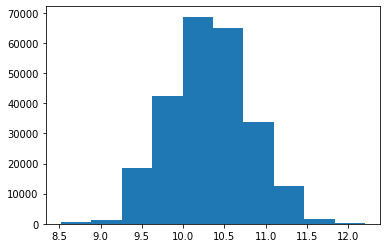

In [ ]:
plt.hist(data['Log1pSalary'])

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row in data[['Title', 'FullDescription']].values:
  for el in row:
    token_counts.update(el.split())

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

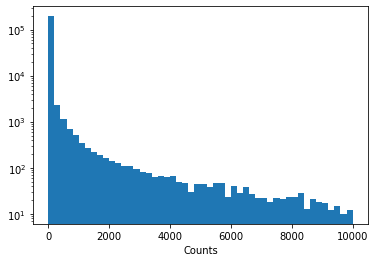

In [ ]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= 10]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict()

for i, word in enumerate(tokens):
  token_to_id[word] = i

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  35,   17,  417,   19,  125,   46,   49,    0, 1783, 1046],
        [1344, 1594,  130, 1178,  857,  778, 1537,  857, 5127,    8],
        [ 520, 1785,  901,  130, 3224,  130,   32, 6711,   15, 3487]],
       dtype=int32),
 'Log1pSalary': array([10.199175 ,  9.7981825, 10.59666  ], dtype=float32),
 'Title': array([[2380,  266, 2929],
        [1344, 1594,    1],
        [ 520, 5688, 3224]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h

In [ ]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Linear(160, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.layers(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.out(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	8.22521
	MAE:	26635.23532



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.63022
	MAE:	7426.68914



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.56545
	MAE:	7046.98610



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.44843
	MAE:	5639.08074



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.38659
	MAE:	5791.99630



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33971
	MAE:	5228.32173



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.33114
	MAE:	5248.94904



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29382
	MAE:	4857.83962



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.30526
	MAE:	5008.16797



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25572
	MAE:	4697.35684



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26051
	MAE:	4703.76108



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23114
	MAE:	4448.11226



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22013
	MAE:	4324.33578



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22015
	MAE:	4196.66959



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22667
	MAE:	4304.94820



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21743
	MAE:	4629.78098



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20457
	MAE:	4134.37032



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19020
	MAE:	4121.36468



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19487
	MAE:	4151.57340



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18862
	MAE:	3898.06990



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18659
	MAE:	4044.48234



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19334
	MAE:	4428.95381



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18019
	MAE:	4033.86267



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18237
	MAE:	4286.02869



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17527
	MAE:	3954.74131



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16615
	MAE:	3679.70031



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15854
	MAE:	3726.02638



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16317
	MAE:	3629.58658



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15628
	MAE:	3704.44097



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16806
	MAE:	3645.30077



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15784
	MAE:	3804.95511



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14492
	MAE:	3488.26642



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14014
	MAE:	3508.60858



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15302
	MAE:	3529.82443



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13647
	MAE:	3406.81958



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13675
	MAE:	3449.20646



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12839
	MAE:	3358.30770



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13993
	MAE:	3413.62767



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13799
	MAE:	3530.62027



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13100
	MAE:	3374.74091



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12745
	MAE:	3373.19657



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13858
	MAE:	3393.39699



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12909
	MAE:	3408.90567



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12389
	MAE:	3375.21394



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12753
	MAE:	3408.03700



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14352
	MAE:	3871.67985



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12969
	MAE:	3562.63790





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

My model is: 
1. As we did in CNN in CV, I added Batch Normalization and dropout in Description Encoder and LSTM in title encoder 
2. Batch size 128

####Result is 2524 MAE


What I did too:
1. 2 parallel convolution (with batchnorm and dropout) with kernel sizes 1 and 3 in description did it a bit worse
2. Change methods of title and description. I'm not sure about the result because training time was too slow and I didn't make much epoches.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class NewTitleEncoder(nn.Module):

""'comment my other try"""
    # def __init__(self, n_tokens=len(tokens), out_size=64):
    #     """ 
    #     A simple sequential encoder for titles.
    #     x -> emb -> conv -> global_max -> relu -> dense
    #     """
    #     super(self.__class__, self).__init__()
    #     self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
    #     self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
    #     self.pool1 = GlobalMaxPooling()
    #     self.bn1 = nn.BatchNorm1d(out_size)
    #     self.dropout1 = nn.Dropout(0.5)        
    #     self.dense = nn.Linear(out_size, out_size)
    #     self.relu = nn.ReLU()

    # def forward(self, text_ix):
    #     """
    #     :param text_ix: int64 Variable of shape [batch_size, max_len]
    #     :returns: float32 Variable of shape [batch_size, out_size]
    #     """
    #     h = self.emb(text_ix)

    #     # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
    #     h = torch.transpose(h, 1, 2)
        
    #     # Apply the layers as defined above. Add some ReLUs before dense.
    #     h = self.conv1(h)
    #     h = self.pool1(h)
    #     h = self.bn1(h)
    #     h = self.dropout1(h)
    #     h = self.relu(h)
    #     h = self.dense(h)
        
        # return h
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.rnn = nn.LSTM(
            input_size=64,
            hidden_size=100,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        ) 
        self.pool = GlobalMaxPooling(dim=1)
        self.dense = nn.Linear(200, out_size)

    def forward(self, text_ix, hidden=None):
        h = self.emb(text_ix)
        output, hidden = self.rnn(h, hidden)
        h = self.pool(output)
        h = self.dense(h)
        return h

In [ ]:
class NewDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.bn1 = nn.BatchNorm1d(out_size)
        self.dropout1 = nn.Dropout(0.5)        
        self.dense = nn.Linear(out_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = self.bn1(h)
        h = self.dropout1(h)
        h = self.relu(h)
        h = self.dense(h)
        
        return h



In [ ]:
class NewFullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = NewTitleEncoder(out_size=64)
        self.desc_encoder = NewDescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.layers = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Linear(160, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.layers(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.out(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [ ]:
model = NewFullNetwork()
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 128
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	18.81174
	MAE:	65744.97950



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.98713
	MAE:	10042.24257



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.86327
	MAE:	10981.92127



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.43095
	MAE:	7244.16555



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.38613
	MAE:	6463.61845



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32468
	MAE:	4990.31029



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.31492
	MAE:	5375.53216



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20159
	MAE:	4236.80542



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21580
	MAE:	4458.96976



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19214
	MAE:	4050.06881



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18929
	MAE:	4241.60158



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18583
	MAE:	3997.46413



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16282
	MAE:	3906.67161



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15984
	MAE:	4014.00465



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15065
	MAE:	3881.48288



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17292
	MAE:	3890.79836



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13476
	MAE:	3565.90596



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14531
	MAE:	3799.00171



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12523
	MAE:	3442.48694



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12558
	MAE:	3446.28342



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14715
	MAE:	3641.16889



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11678
	MAE:	3242.72382



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11612
	MAE:	3259.72478



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16944
	MAE:	3881.99036



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12449
	MAE:	3354.40477



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10725
	MAE:	3146.68890



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10817
	MAE:	3088.25730



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10906
	MAE:	3203.73847



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10583
	MAE:	3086.24304



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10821
	MAE:	3194.31432



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10368
	MAE:	3138.68466



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09986
	MAE:	3033.08372



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10730
	MAE:	3052.92792



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10381
	MAE:	3050.13163



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11199
	MAE:	3268.81854



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09752
	MAE:	2977.70837



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09796
	MAE:	3011.02378



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11496
	MAE:	3215.68872



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10160
	MAE:	3001.79617



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09436
	MAE:	2910.31474



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09586
	MAE:	2935.85631



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09338
	MAE:	2902.13516



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08847
	MAE:	2933.38566



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09196
	MAE:	2893.63800



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09499
	MAE:	2938.61678



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09775
	MAE:	2966.14022



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09621
	MAE:	2881.78901



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09376
	MAE:	2890.97294



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09391
	MAE:	2915.66419



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09220
	MAE:	2915.97094



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09449
	MAE:	2928.24044



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10594
	MAE:	3093.10421



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10280
	MAE:	3044.84669



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09016
	MAE:	2872.35697



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09190
	MAE:	2955.62271



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09592
	MAE:	3015.74880



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09499
	MAE:	2962.89866



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09670
	MAE:	3026.98454



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08164
	MAE:	2710.31845



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10225
	MAE:	3014.50609



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08354
	MAE:	2778.60232



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08524
	MAE:	2768.76372



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09277
	MAE:	2809.85008



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09660
	MAE:	2940.92973



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08970
	MAE:	2872.65207



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08456
	MAE:	2773.37881



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08559
	MAE:	2868.36324



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08725
	MAE:	2844.07724



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08550
	MAE:	2842.44526



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08677
	MAE:	2779.38040



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09982
	MAE:	2974.92571



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08396
	MAE:	2761.36098



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08886
	MAE:	2851.88091



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08846
	MAE:	2808.82362



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08945
	MAE:	2814.27630



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08398
	MAE:	2753.04125



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08276
	MAE:	2781.71068



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08662
	MAE:	2789.44246



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08656
	MAE:	2801.58378



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08340
	MAE:	2737.23077



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08485
	MAE:	2718.92959



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08542
	MAE:	2816.10017



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08625
	MAE:	2792.40743



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08541
	MAE:	2776.86024



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08465
	MAE:	2755.45702



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08452
	MAE:	2753.62938



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08738
	MAE:	2775.42848



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16608
	MAE:	3914.04930



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08960
	MAE:	2923.61629



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08046
	MAE:	2695.93596



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09035
	MAE:	2897.98945



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09486
	MAE:	2913.95184



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09210
	MAE:	2873.69531



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07963
	MAE:	2678.37837



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08685
	MAE:	2812.18328



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08433
	MAE:	2767.26518



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08774
	MAE:	2768.57346



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08583
	MAE:	2835.33537



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08449
	MAE:	2783.46985



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11030
	MAE:	3180.91983



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08715
	MAE:	2869.59033



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08000
	MAE:	2675.71004



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08792
	MAE:	2871.35152



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07977
	MAE:	2696.55863



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08678
	MAE:	2754.77764



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07834
	MAE:	2652.98127



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08244
	MAE:	2686.79469



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08460
	MAE:	2758.09583



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08039
	MAE:	2710.44552



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08507
	MAE:	2757.47042



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08317
	MAE:	2808.41600



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08011
	MAE:	2673.06709



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08058
	MAE:	2697.86074



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07802
	MAE:	2666.52595



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07738
	MAE:	2684.25949



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10177
	MAE:	3048.71519



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08277
	MAE:	2778.09371



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07619
	MAE:	2612.25089



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08171
	MAE:	2609.43448



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07695
	MAE:	2626.52336



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08213
	MAE:	2724.98133



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08874
	MAE:	2828.09926



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09607
	MAE:	2941.37353



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07692
	MAE:	2623.83641



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07867
	MAE:	2640.81479



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08014
	MAE:	2682.76904



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08082
	MAE:	2635.40694



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08653
	MAE:	2782.20193



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07585
	MAE:	2665.84612



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07516
	MAE:	2592.61300



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07818
	MAE:	2690.07338



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07779
	MAE:	2674.41034



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08363
	MAE:	2753.88842



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07433
	MAE:	2580.94364



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08172
	MAE:	2786.78531



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07641
	MAE:	2629.76938



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07913
	MAE:	2762.75518



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07416
	MAE:	2568.22093



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08033
	MAE:	2676.83661



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08103
	MAE:	2694.57869



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07563
	MAE:	2595.11333



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07441
	MAE:	2577.99923



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07183
	MAE:	2586.86270



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08821
	MAE:	2908.01117



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07494
	MAE:	2611.21319



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07424
	MAE:	2566.56551



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08240
	MAE:	2762.75803



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09605
	MAE:	3126.19495



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07216
	MAE:	2545.87750



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07865
	MAE:	2688.92190



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07266
	MAE:	2571.05884



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07421
	MAE:	2561.83147



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07788
	MAE:	2708.69762



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07499
	MAE:	2580.28535



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07936
	MAE:	2683.92613



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07818
	MAE:	2694.35745



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07392
	MAE:	2562.85157



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07487
	MAE:	2577.19624



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06967
	MAE:	2535.02103



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08518
	MAE:	2762.72437



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07570
	MAE:	2601.82584



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07590
	MAE:	2596.43922



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07980
	MAE:	2623.69074



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07493
	MAE:	2589.81552



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07958
	MAE:	2622.96198



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08210
	MAE:	2787.06794



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08318
	MAE:	2765.65776



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08068
	MAE:	2673.64134



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06752
	MAE:	2558.12306



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07442
	MAE:	2588.86147



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07353
	MAE:	2596.82609



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07911
	MAE:	2733.23752



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07402
	MAE:	2615.06776



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07647
	MAE:	2638.49187



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07284
	MAE:	2586.68673



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08266
	MAE:	2801.22249



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07878
	MAE:	2641.61653



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07296
	MAE:	2572.56564



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07184
	MAE:	2551.33283



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07262
	MAE:	2538.47091



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07109
	MAE:	2569.77548



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07247
	MAE:	2550.47564



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08002
	MAE:	2645.80045



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07594
	MAE:	2601.67940



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06906
	MAE:	2537.99101



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07777
	MAE:	2631.02744



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07363
	MAE:	2626.43970



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07094
	MAE:	2509.49881



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07260
	MAE:	2547.61736



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07288
	MAE:	2526.68949



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07747
	MAE:	2649.60011



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07154
	MAE:	2522.94952



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06719
	MAE:	2454.61844



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07267
	MAE:	2537.54076



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06841
	MAE:	2507.45165



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10185
	MAE:	3252.84669



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07111
	MAE:	2546.13924



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06999
	MAE:	2481.68126



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07601
	MAE:	2640.93097



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07127
	MAE:	2524.84956





In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07127
	MAE:	2524.84956



